In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Class container for operations in the math graph
# _children will be a tuple
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        # It is going to store the chain rule at each node
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        
        # Here we are going to implement the derivative of the 'parent' node (neuron)
        # with respect to the chield nodes
        # p = parent, c1 = chield1, c2 = chield2
        # p = c1 + c2
        # dp/dc1 = 1 = dp/dc2
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        
        # p = parent, c1 = chield1, c2 = chield2
        # p = c1 * c2
        # dp/dc1 = c2
        # dp/dc2 = c1
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
    
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        # We can represent a division like a product or exponentiation
        # Like a product:  4/2 == 4 * (1/2) == 4 * 2^-1
        # a/b == a*(1/b) == a*(b**-1)
        return self * other**(-1)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')
        
        # p = parent, c1 = chield1
        # p = tanh(c1)
        # dp/dc1 = 1 - tanh(c1)^2
        # dp/dc1 = 1 - p^2
        # L = lost function (output of the last neuron)
        # dL/dc1 = dL/dp * dp/dc1
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] # Nodes (Neurons) ordered backward according to the graph
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for chield in node._prev:
                    build_topo(chield)
                topo.append(node)

        build_topo(self)
        self.grad = 1.0 # Initial derivative of the last note with respect itself
        for node in reversed(topo):
            node._backward()    

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(node):
        # Add the current node to the nodes if not present
        if node not in nodes:
            nodes.add(node)
            print(f"{node.data}, child: {node._prev}, operation: {node._op}")
        # For every child of node save the child and node in edges, and add
        # the child as other node calling build(child)
        for child in node._prev:
            edges.add((child, node))
            build(child)
            
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    print("\n")
    print(f"nodes: {nodes}\nedges: {edges}")
    for nod in nodes:
        uid = str(id(nod))
        # For any value in the graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (nod.label, nod.data, nod.grad), shape='record')
        if nod._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + nod._op, label=nod._op)
            # and connect this node to it
            dot.edge(uid + nod._op, uid)
            
    for nod1, nod2 in edges:
        # Connect nod1 to the op node of nod2
        dot.edge(str(id(nod1)), str(id(nod2)) + nod2._op)
    
    return dot
        
      

0.7071067811865476, child: {Value(data=0.8813735870195432)}, operation: tanh
0.8813735870195432, child: {Value(data=-6.0), Value(data=6.881373587019543)}, operation: +
-6.0, child: {Value(data=0.0), Value(data=-6.0)}, operation: +
0.0, child: {Value(data=0.0), Value(data=1.0)}, operation: *
0.0, child: set(), operation: 
1.0, child: set(), operation: 
-6.0, child: {Value(data=2.0), Value(data=-3.0)}, operation: *
2.0, child: set(), operation: 
-3.0, child: set(), operation: 
6.881373587019543, child: set(), operation: 


nodes: {Value(data=0.8813735870195432), Value(data=6.881373587019543), Value(data=0.0), Value(data=-3.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=-6.0), Value(data=2.0), Value(data=0.7071067811865476)}
edges: {(Value(data=1.0), Value(data=0.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=2.0), Value(data=-6.0)), (Value(data=6.881373587019543), Value(d

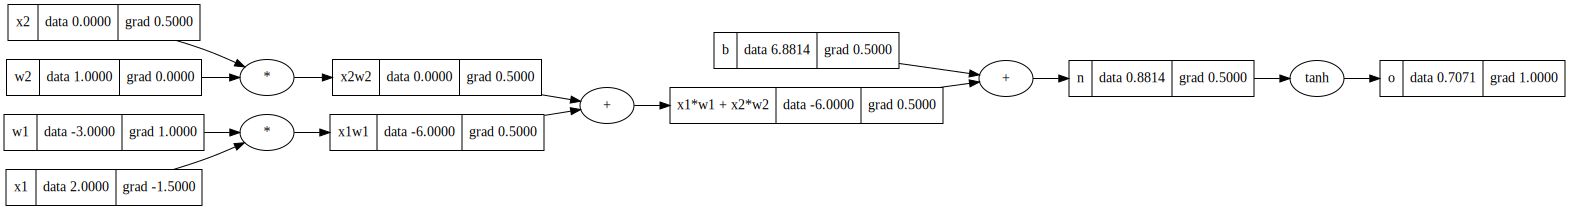

In [14]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Dot product between weights, inputs and bias
# output = (weights . inputs) + bias
# w1x1 + w2x2 + b 
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)

### Let's represent Tanh as a compose function

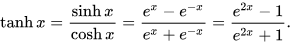

0.7071067811865477, child: {Value(data=0.1464466094067262), Value(data=4.828427124746192)}, operation: *
0.1464466094067262, child: {Value(data=6.828427124746192)}, operation: **-1
6.828427124746192, child: {Value(data=1), Value(data=5.828427124746192)}, operation: +
1, child: set(), operation: 
5.828427124746192, child: {Value(data=1.7627471740390863)}, operation: exp
1.7627471740390863, child: {Value(data=0.8813735870195432), Value(data=2)}, operation: *
0.8813735870195432, child: {Value(data=-6.0), Value(data=6.881373587019543)}, operation: +
-6.0, child: {Value(data=-6.0), Value(data=0.0)}, operation: +
-6.0, child: {Value(data=-3.0), Value(data=2.0)}, operation: *
-3.0, child: set(), operation: 
2.0, child: set(), operation: 
0.0, child: {Value(data=0.0), Value(data=1.0)}, operation: *
0.0, child: set(), operation: 
1.0, child: set(), operation: 
6.881373587019543, child: set(), operation: 
2, child: set(), operation: 
4.828427124746192, child: {Value(data=-1), Value(data=5.828427

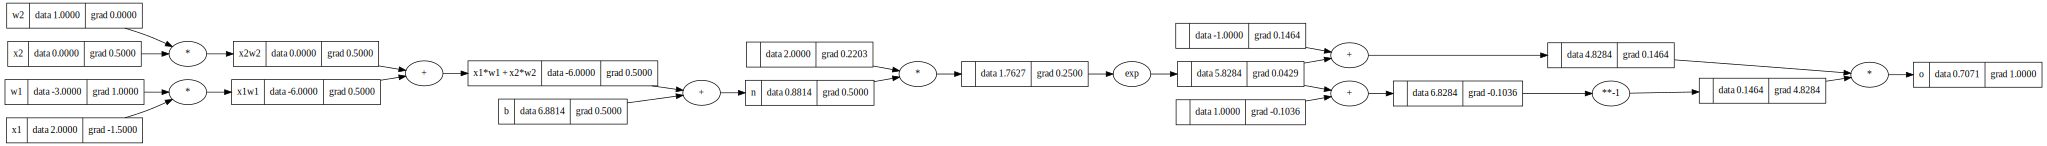

In [17]:
# Inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Dot product between weights, inputs and bias
# output = (weights . inputs) + bias
# w1x1 + w2x2 + b 
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
#-----
e = (2*n).exp()
o = (e-1)/(e+1)
#-----
o.label='o'
o.backward()
draw_dot(o)

In [ ]:
# Note:
# The level at which we implement the operations is up to us, we can
# implement backward passes for tiny expressions like a single individual plus or multiplication.
# Or we can implement it for tanh which is a composite operation.

# What matters is that we have some kind of inputs and some kind of outputs. Where
# the output is a function of the inputs in some way and as long as we can do forwar pass and the backward
# pass of that little operation it doesn't matter what operation is and how composite it is.

# I we can write the local gradients we can change the gradient and we can continue backpropagation
# So the design of what those functions are is completely up to us.